<a href="https://colab.research.google.com/github/mcortes-lopez/CD19_splicing_mutagenesis/blob/main/DeepRiPe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setups
It is necesary to clone the repository in order to get the functions writen in the Scripts folder to run. 

I noticed is not specified the requiriment of the "concise" models (Developed by the Gagneur lab https://github.com/gagneurlab/concise), therefore it must be installed previous to the use of the scripts, at least it is in *pip*.







In [ ]:
!git clone https://github.com/ohlerlab/DeepRiPe.git

fatal: destination path 'DeepRiPe' already exists and is not an empty directory.


In [ ]:
pip install concise

     |████████████████████████████████| 1.3MB 2.7MB/s 
     |████████████████████████████████| 317kB 16.5MB/s 
  Created wheel for gtfparse: filename=gtfparse-1.2.0-cp36-none-any.whl size=11883 sha256=d1e9dfdbef2c983036533c8d8144ef40fa817911c9d507f87d024fb56a665e9f
  Stored in directory: /root/.cache/pip/wheels/c4/27/96/6ba6fe28cbb162c326823553e3e45ac502160d1340566360f8
Successfully built gtfparse
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


With the previous installation Tensorflow is updated, however the scripts required a earlier version. The solution: downgrade Tensorflow.

In [ ]:
pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 27kB/s 
     |████████████████████████████████| 512kB 38.2MB/s 
     |████████████████████████████████| 3.8MB 43.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=0a1b93be1524870c26ac42c853dc7baba1cd54f0f5364dd966a33949981e26e0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

I have copied the full repository from Github, now we will follow some of the notebooks

In [ ]:
import os
import numpy as np
import h5py
import scipy.io
np.random.seed(7) # for reproducibility

import keras.backend as K
from keras.models import Model, load_model

import matplotlib.pyplot as plt
import matplotlib
#from concise.utils.plot import seqlogo, seqlogo_fig

import sys
sys.path.append("DeepRiPe/Scripts")
from IntegratedGradients import *
from util_funcs import *
from plotseqlogo import seqlogo, seqlogo_fig

2020-06-24 12:15:41,614 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-06-24 12:15:41,642 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
DeepRiPe/Scripts/plotseqlogo.py:44: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
DeepRiPe/Scripts/plotseqlogo.py:45: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


## Getting the external data: PAR-CLIP Models

The following lines download and extract the data of the models. So far this is not required to run the notebooks, because, I believe, in the repository there is a light version of these models.

In [ ]:
!wget http://bimsbstatic.mdc-berlin.de/ohler/DeepRiPe/Data.tar.gz

--2020-06-18 11:02:32--  http://bimsbstatic.mdc-berlin.de/ohler/DeepRiPe/Data.tar.gz
Resolving bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)... 141.80.181.47, 141.80.181.46
Connecting to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.47|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bimsbstatic.mdc-berlin.de/ohler/DeepRiPe/Data.tar.gz [following]
--2020-06-18 11:02:32--  https://bimsbstatic.mdc-berlin.de/ohler/DeepRiPe/Data.tar.gz
Connecting to bimsbstatic.mdc-berlin.de (bimsbstatic.mdc-berlin.de)|141.80.181.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275393486 (263M) [application/octet-stream]
Saving to: ‘Data.tar.gz’

Data.tar.gz         100%[===================>] 262.63M  23.4MB/s    in 13s     

2020-06-18 11:02:45 (20.5 MB/s) - ‘Data.tar.gz’ saved [275393486/275393486]



In [ ]:
!tar -xvf Data.tar.gz

Data/data_RBPshigh.h5
Data/data_RBPsmed.h5
Data/data_RBPslow.h5
Data/


## Loading models and obtain integrated gradients

In [ ]:
#load models and obtain integrated gradients
path_to_model = "/content/DeepRiPe/Results/PARCLIP_models/" # This line is adapted to the Colab enviroment
path_to_modelhigh= path_to_model + "model_RBPshigh.h5"
path_to_modelmed= path_to_model + "model_RBPsmed.h5"
path_to_modellow= path_to_model + "model_RBPslow.h5"

model_high=load_model(path_to_modelhigh, custom_objects={'precision': precision,'recall': recall }) 
igres_high = integrated_gradients(model_high) 

model_med=load_model(path_to_modelmed, custom_objects={'precision': precision,'recall': recall }) 
igres_med = integrated_gradients(model_med) 

model_low=load_model(path_to_modellow, custom_objects={'precision': precision,'recall': recall }) 
igres_low = integrated_gradients(model_low) 

#RBPnames for each model
RBPnames_low=np.array(['MBNL1', 'P53_NONO', 'PUM2', 'QKI', 'AGO3', 'FUS', 'TAF15', 'ZFP36', 'DICER1', 'EIF3A', 'EIF3D', 'EIF3G', 'SSB', 'PAPD5', 'CPSF4', 'CPSF3', 'RTCB', 'FXR1', 'NOP58', 'NOP56', 'FBL', 'LIN28A', 'LIN28B', 'UPF1', 'G35', 'G45', 'XPO5'])
RBPnames_med=np.array(['TARDBP', 'ELAVL2', 'ELAVL3', 'ELAVL4', 'RBM20', 'IGF2BP1', 'IGF2BP2', 'IGF2BP3', 'EWSR1', 'HNRNPD', 'RBPMS', 'SRRM4', 'AGO2', 'NUDT21', 'FIP1L1', 'CAPRIN1', 'FMR1iso7', 'FXR2', 'AGO1', 'L1RE1', 'ORF1'])
RBPnames_high=np.array(['DND1', 'CPSF7', 'CPSF6', 'CPSF1', 'CSTF2', 'CSTF2T', 'ZC3H7B', 'FMR1iso1', 'RBM10', 'MOV10', 'ELAVL1'])

2020-06-18 11:04:44,131 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2020-06-18 11:04:44,158 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2020-06-18 11:04:44,282 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



2020-06-18 11:04:44,296 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2020-06-18 11:04:44,298 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2020-06-18 11:04:44,316 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2020-06-18 11:04:44,497 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2020-06-18 11:04:44,499 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2020-06-18 11:04:44,502 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2020-06-18 11:04:44,761 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2020-06-18 11:04:44,767 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



2020-06-18 11:04:44,918 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2020-06-18 11:04:45,959 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-06-18 11:04:45,966 [WARNING] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-06-18 11:04:46,339 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2020-06-18 11:04:46,475 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Evaluated output channel (0-based index): All
Building gradient functions


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 4.7%

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 3.7%

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Progress: 100.0%
Done.


In [ ]:
len(RBPnames_low) + len(RBPnames_med) + len(RBPnames_high)

59

DeepRiPe/Scripts/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


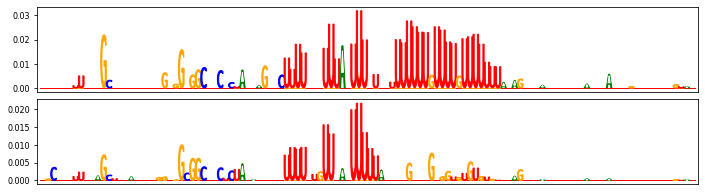

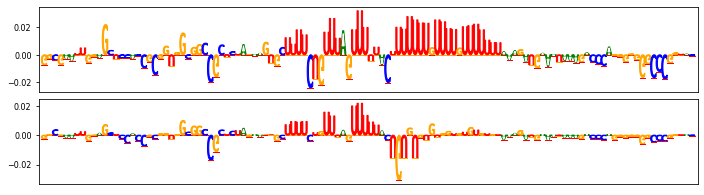

In [ ]:
WT1="GGGCGAAUUGGAGCUCCACCGCGGUGGCGGCCGCUCUAGAAGUGCUUUUCUGUUUAGUUUUUACUUUUUUUGUUUUGUUUUUUUAAAGAUGAAAUAAAGACCCAGGGGGGGCCCGGUAC"
MT1="GGGCGAAUUGGAGCUCCACCGCGGUGGCGGCCGCUCUAGAAGUGCUUUUCUGUUUAGUUUUUACUgUgUgUGUggUGUgUgUgUAAAGAUGAAAUAAAGACCCAGGGGGGGCCCGGUAC"

### Add Ns so that the size is equal to the input size(150)
ELAVL1 = np.array([seq_to_mat("N"*31+WT1),seq_to_mat("N"*31+MT1)]) 
ch_ind = np.where(RBPnames_high=="ELAVL1")[0][0]
ind=[0,1]

reg_coded=np.full((250, 4), 0.25)

seqin=np.array([seq_to_mat("N"*31+WT1),seq_to_mat("N"*31+MT1)])
regin=np.array([reg_coded,reg_coded])

ind=[0,1]
ex_seq = np.array([igres_high.explain([seqin[i],regin[i]],outc=ch_ind,reference=False)[0] for i in ind])

plt.close("all")


### showing only positive attributions
seqlogo_fig(np.transpose(ex_seq[:,32:150,:4].clip(min=0, max=None),axes=(1,2,0)), vocab="RNA", figsize=(10,3), ncol=1)
plt.show()


### showing all attributions
seqlogo_fig(np.transpose(ex_seq[:,32:150,:4],axes=(1,2,0)), vocab="RNA", figsize=(10,3), ncol=1)
plt.show()

DeepRiPe/Scripts/plotseqlogo.py:160: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([],[])


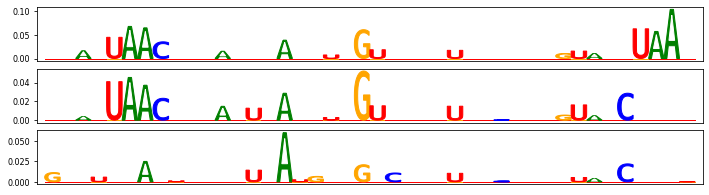

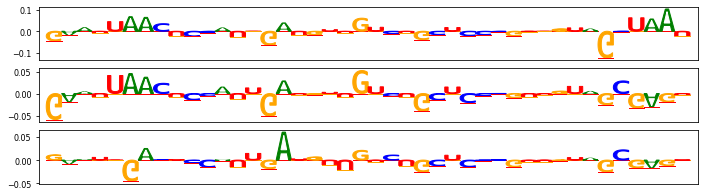

In [ ]:
seqbase1="GAATTAACTCCATTGATGTTGTCTGCTCCCGTTGTAGCTAAT"
seqbase2="GAATTAACTCCATTGATGTTGTCTGCTCCCGTTGTAGCgAgT"
seqbase3="GAATTgACTCCATTGATGTTGTCTGCTCCCGTTGTAGCgAgT"

seqw="n"*54+seqbase1+"n"*54
seqm1="n"*54+seqbase2+"n"*54
seqm2="n"*54+seqbase3+"n"*54

seqw_coded=seq_to_mat(seqw) 
seqm1_coded=seq_to_mat(seqm1) 
seqm2_coded=seq_to_mat(seqm2) 

reg_coded=np.full((250, 4), 0.25)

seqin=np.array([seqw_coded,seqm1_coded,seqm2_coded])
regin=np.array([reg_coded,reg_coded,reg_coded])

ch_ind=np.where(RBPnames_low=="QKI")[0][0]

ind=[0,1,2]
ex_seq = np.array([igres_low.explain([seqin[i],regin[i]],outc=ch_ind,reference=False)[0] for i in ind])

### showing only positive attributions
plt.close("all")
seqlogo_fig(np.transpose(ex_seq[:,54:96,:4].clip(min=0, max=None),axes=(1,2,0)), vocab="RNA", figsize=(10,3), ncol=1)

plt.show()

### showing all attributions
seqlogo_fig(np.transpose(ex_seq[:,54:96,:4],axes=(1,2,0)), vocab="RNA", figsize=(10,3), ncol=1)
plt.show()



CD19 exploration of variants 